In [1]:
%cd '/playpen-storage/levlevi/contextualized-shot-quality-analysis/shot-quality-estimation/dataset_prep'

import sys
sys.path.append("/playpen-storage/levlevi/contextualized-shot-quality-analysis/TimeSformer")

/playpen-storage/levlevi/contextualized-shot-quality-analysis/shot-quality-estimation/dataset_prep


In [2]:
import time

from extract_shot_attempts import *
from truncate_clips import *
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from paths import *

MODEL_FP = (
    LOCAL_DIR
    + "contextualized-shot-quality-analysis/data/experiments/__runs__/result-noise-cls/nba_result_cls_1k_32_frames_224/checkpoints/checkpoint_epoch_00020.pyth"
)
SHOT_OFFSET_SEC = 5 # start clip 5 seconds before timestamps
TEMP_SHOT_DURATION_SEC = 8
OUT_SHOT_DURATION_SEC = 4

In [3]:
device = 0
timesformer_model = get_model(device=device, model_path=MODEL_FP)

In [4]:
# 17594_800201_2+_42.927
ex_fp = "/playpen-storage/levlevi/contextualized-shot-quality-analysis/data/experiments/test-sets/result-shown/result_shown_test_nba_3.2k_8s/made/17597_800201_2+_60.318.mp4"
start = time.time()
video_tensor = read_video_to_tensor_buffer(ex_fp, device)
end = time.time()
print(f"Read in video in {end-start}s")

start = time.time()
conf_scores, timestamps, = pred_conf_scores(video_tensor, device=device, model=timesformer_model, step_size=2)
end = time.time()
print(f"Predictions completed in {end-start}s")

Read in video in 1.063779592514038s
Predictions completed in 12.360162496566772s


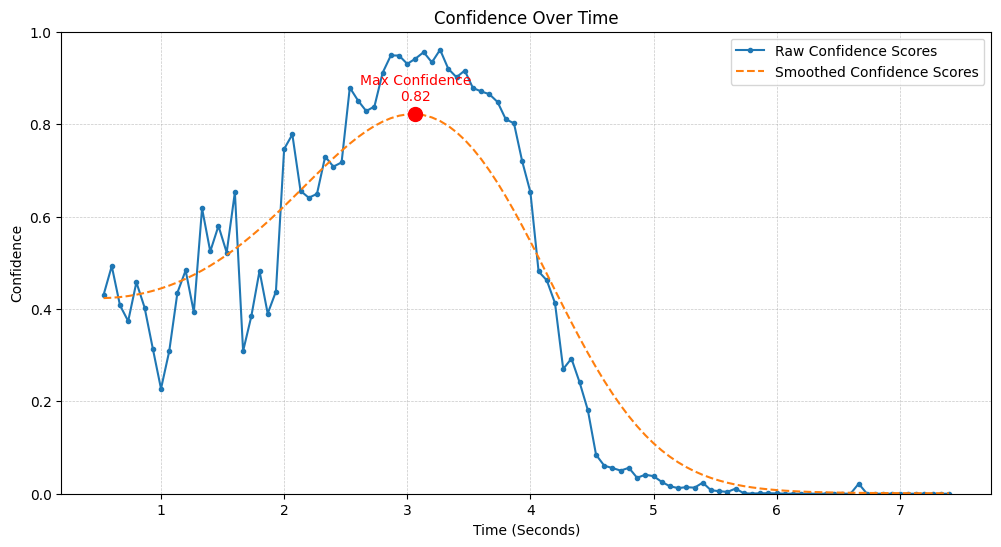

In [5]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# # Extracting the first confidence score from each tensor
idv_confidence_scores = [tensor.cpu()[0][0].item() for tensor in conf_scores]
smoothed_confidence_scores = gaussian_filter1d(idv_confidence_scores, sigma=9)
max_idx = get_highest_conf_idx(conf_scores, sigma=9)

# Create the plot
plt.figure(figsize=(12, 6))  # Slightly larger for better visibility
plt.plot(timestamps, idv_confidence_scores, label='Raw Confidence Scores', marker='.', linestyle='-')
plt.plot(timestamps, smoothed_confidence_scores, label='Smoothed Confidence Scores', linestyle='--')

# Highlight the point with the maximum smoothed confidence
plt.plot(timestamps[max_idx], smoothed_confidence_scores[max_idx], 'ro', markersize=10)  # Larger marker

# Adding labels and title
plt.xlabel('Time (Seconds)')
plt.ylabel('Confidence')
plt.title('Confidence Over Time')
plt.legend()

# Set y-axis limits to clarify the 'noise' to 'shot-result' scale
plt.ylim(0, 1)

# Add gridlines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate the maximum point
plt.annotate(f'Max Confidence\n{smoothed_confidence_scores[max_idx]:.2f}',
             (timestamps[max_idx], smoothed_confidence_scores[max_idx]),
             textcoords="offset points",  # how to position the text
             xytext=(0,10),  # distance from text to points (x,y)
             ha='center',  # horizontal alignment can be left, right or center
             color='red')

plt.show()